In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 🧩 Why We Need the ReAct (Reasoning + Action) Pattern

Large Language Models (LLMs) are **excellent text predictors**, not true reasoners.  
They don’t *know* facts — they **guess the next word** from patterns in data.

---

## ⚙️ The Limitation

- Works great for *static knowledge* (“What is gravity?”)  
- Fails for *dynamic or fact-based tasks* (“What’s the weather right now?”)  
- Sounds confident, but it’s just **pattern recall — not reasoning**  
- A plain LLM **cannot fetch data, call APIs, or verify its own steps**

---

## 💡 The Insight

Real intelligence isn’t only about *knowing* — it’s about **deciding when to think, when to act, and when to verify**.  



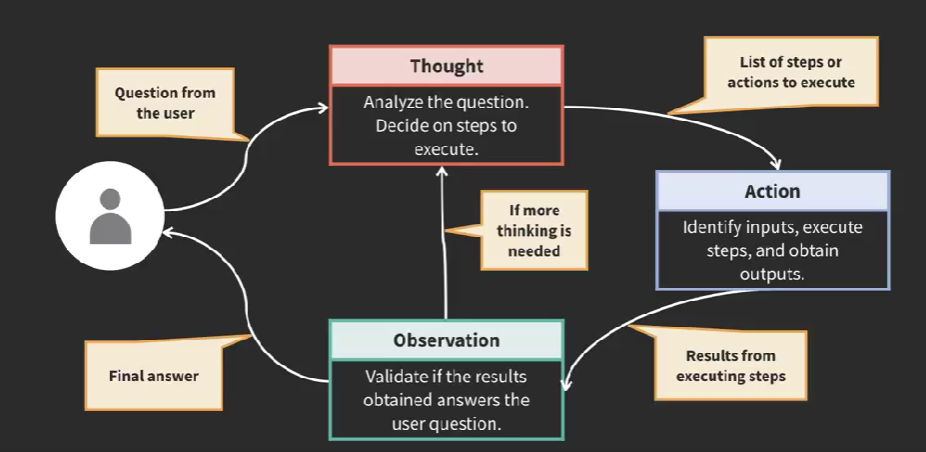

In [12]:
from IPython.display import Image, display
display(Image(filename='/content/ReActFramework.png', width=1000, height=500))


The **ReAct** (Reason + Act) pattern gives an LLM the ability to not just *generate* responses,  
but to **reason**, **decide**, **interact**, and **verify** before answering.

- 🧠 **Thought** — The agent decides what to do next.  
- ⚙️ **Action** — It calls a tool or API to gather evidence.  
- 👀 **Observation** — It reads and interprets the result.  
- 💬 **Reflection** — It reasons about the new context.  
- ✅ **Final Answer** — It responds confidently, grounded in data.

This loop transforms an LLM from a passive text generator  
into an **interactive decision-making system** — the foundation of *Agentic AI*.


# Big Picture



1.   ReAct turns language models into **interactive problem solvers**. They don’t just recall information — they **engage with the environment**.

2.   It’s the bridge between:
     - **Knowledge and Action**  
     - **Prediction and Decision**  
     - **Chatbots and Agents**

# Key Takeaway


1.  **LLMs predict.**
2. **ReAct Agents decide.**

  **This simple shift**: from generating words to taking actions  marks the beginning of **Agentic AI**.

In [ ]:
!pip install tenacity==9.0.0
!pip install langchain==0.3.12
!pip install langchain-openai==0.2.12
!pip install langchain_community==0.3.12
!pip install langgraph==0.2.59
!pip install pysqlite3-binary==0.5.4
!pip install langchain_chroma==0.1.4
!pip install pandas==2.2.3
!pip install pypdf==5.1.0
!pip install nbformat==5.10.4

# ReAct Agent from Scratch - without frameworks

### 🧠 What ReAct Graph (in the coming cell) Is Really Doing

This code builds a tiny **ReAct runtime** for a health assistant:

- `AgentState` is the **memory**:
  - the user query,
  - the last LLM message,
  - all tool observations,
  - and a step counter.

- `call_model(state)` is the **Reasoning node**:
  - It reads the state,
  - shows the LLM the tools (`calculate_bmi`, `daily_water_intake`),
  - and forces the model to answer in a strict format:
    - either **THOUGHT + ACTION + ARGUMENTS**  
    - or **THOUGHT + ANSWER**.

- `tools_node(state)` is the **Action node**:
  - It parses the model’s `ACTION` and `ARGUMENTS`,
  - calls the real Python tools,
  - and appends human-readable observations back into the state.

- `should_continue(state)` is the **loop controller**:
  - If we see `ANSWER:`, we stop.
  - If we see `ACTION:`, we go to `tools`.
  - Otherwise, we end as a safety fallback.

- `StateGraph` wires this into a loop:
  - `agent → tools → agent → …`  
  - until the LLM chooses to **stop with an ANSWER**.

So we have a complete **Thought → Action → Observation → Answer** loop,
implemented as a **graph over a simple Python dict**.


# Setup OpenAI API Key

In [3]:
import os, textwrap
from openai import OpenAI
import getpass

# Prompt user for a password (input hidden)
OPENAI_API_KEY = getpass.getpass("Enter your password: ")


Enter your password: ··········


In [4]:
import json
from langgraph.graph import StateGraph, END
from typing import TypedDict

# === State Schema ===
class AgentState(TypedDict):
    query: str
    last_agent_response: str
    tool_obervations: list
    num_steps: int

# === Stateless Tool Functions (from the other notebook) ===

def calculate_bmi(weight_kg: float, height_m: float) -> float:
    """
    Compute Body Mass Index (BMI) given weight in kilograms and height in meters.
    Returns the BMI as a float.
    """
    return weight_kg / (height_m ** 2)

def daily_water_intake(weight_kg: float) -> float:
    """
    Estimate recommended daily water intake (in liters) based on body weight.
    Uses a simple heuristic: 35 ml per kg of body weight.
    """
    return round(weight_kg * 0.035, 2)

# === LLM Call Node (ReAct-style prompt) ===

def call_model(state: dict) -> dict:
    print("\n")
    print("=== STEP", state.get("num_steps", 0), "===")
    print("---CALLING LLM MODEL---")

    query = state.get("query", "")
    tool_observations = state.get("tool_obervations", []) # Use the list directly
    last_agent_response = state.get("last_agent_response", "")

    tools_list = """
Available tools:

1. calculate_bmi
Description: Compute Body Mass Index given weight_kg (kg) and height_m (meters).
Arguments: weight_kg (float), height_m (float)

2. daily_water_intake
Description: Estimate recommended daily water intake in liters based on body weight.
Arguments: weight_kg (float)
"""

    # Construct the prompt with clear instructions and history
    prompt = f"""
You are a careful health assistant that follows a ReAct-style loop.

You can think step by step and you can use the following tools to do **all numeric work**:

{tools_list}

User query: "{query}"

Conversation history and tool results:
{''.join(tool_observations)}
{last_agent_response}

You MUST respond in exactly one of these formats:

1) To THINK and ACT (call a tool):

THOUGHT: <your reasoning about what to do next>
ACTION: <tool_name from the list above>
ARGUMENTS: <JSON with the arguments, for example: {{"weight_kg": 72, "height_m": 1.75}}>

2) To GIVE FINAL ANSWER (when no more tools are needed):

THOUGHT: <short reasoning why you can answer now>
ANSWER: <final answer for the user in clear natural language>

Rules:
- When you need BMI, always call calculate_bmi instead of computing directly.
- When you need water recommendation, always call daily_water_intake.
- ARGUMENTS must be valid JSON with double-quoted keys.
- Do NOT mix ANSWER and ACTION in the same response.
- Do NOT mention these formatting rules explicitly to the user.
- **Crucially, look at the "Conversation history and tool results" to understand what has already happened.**
"""

    # Uses get_llm_response defined earlier in your notebook
    response = get_llm_response(prompt)

    state["last_agent_response"] = response
    state["num_steps"] = state.get("num_steps", 0) + 1
    print(response)
    return state

# === Tool Execution Node ===

def tools_node(state: dict) -> dict:
    """
    Parse the last_agent_response, detect ACTION + ARGUMENTS,
    call the corresponding Python tool, and append an observation.
    """
    action_text = state.get("last_agent_response", "")

    # If the model did not choose an ACTION, nothing to do
    if "ACTION:" not in action_text:
        # If no action is found, it might be a final answer, let should_continue handle it
        # state.setdefault("tool_obervations", []).append("[No action found in last response]")
        return state # Don't add observation here, as it might be a valid final answer

    print("\n---CALLING TOOL---")

    # Parse tool name
    try:
        tool_name = action_text.split("ACTION:")[1].split("\n")[0].strip()
        print(f"Tool to call: {tool_name}")
    except IndexError:
        print("Failed to parse tool name from ACTION line.")
        state.setdefault("tool_obervations", []).append(
            "[Failed to parse tool name from ACTION line]"
        )
        return state


    # Parse JSON arguments
    args = {}
    if "ARGUMENTS:" in action_text:
        args_text = action_text.split("ARGUMENTS:")[1].strip()

        # Safely extract the JSON block (handles extra text after it)
        if args_text.startswith("{"):
            brace_count = 0
            end_index = 0
            for i, char in enumerate(args_text):
                if char == "{":
                    brace_count += 1
                elif char == "}":
                    brace_count -= 1
                    if brace_count == 0:
                        end_index = i + 1
                        break
            args_text = args_text[:end_index]

        try:
            args = json.loads(args_text)
            print(f"Parsed arguments: {args}")
        except json.JSONDecodeError:
            print(f"Failed to parse JSON arguments: {args_text}")
            state.setdefault("tool_obervations", []).append(
                f"[Failed to parse arguments: {args_text}]"
            )
            args = {} # Proceed with empty args if parsing fails

    # Map tool names to the actual Python functions
    tool_map = {
        "calculate_bmi": calculate_bmi,
        "daily_water_intake": daily_water_intake,
    }

    if tool_name in tool_map:
        try:
            result = tool_map[tool_name](**args)
            # Save observation
            state.setdefault("tool_obervations", []).append(
                f"[{tool_name} result: {result}]"
            )
            # state["last_tool_results"] = {tool_name: result} # Not used in agent state for now
            print(f"{tool_name} returned:", result)
            return state
        except TypeError as e:
             print(f"Error calling tool {tool_name} with args {args}: {e}")
             state.setdefault("tool_obervations", []).append(
                f"[Error calling tool {tool_name} with args {args}: {e}]"
            )
             return state


    # Unknown tool name
    state.setdefault("tool_obervations", []).append(f"[Unknown tool: {tool_name}]")
    print(f"Unknown tool requested: {tool_name}")
    return state

# === Should Continue? Node ===

def should_continue(state: dict) -> str:
    last_agent_response = state.get("last_agent_response", "")
    # Check for "ANSWER:" case-insensitively
    if "ANSWER:" in last_agent_response.upper():
        print("Found ANSWER in the last action text, ending workflow.")
        return "end"
    # If no ANSWER and an ACTION was found, continue to tools
    if "ACTION:" in last_agent_response.upper():
         print("-- Continuing workflow to tools.")
         return "continue"

    # If neither ANSWER nor ACTION, something unexpected happened.
    # In a real application, you might want better error handling or a fallback.
    # For this example, we'll assume any other case means the agent is done or stuck.
    print("-- Neither ANSWER nor ACTION found. Ending workflow.")
    return "end"


# === Build the LangGraph StateGraph ===

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tools_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"continue": "tools", "end": END}
)

workflow.add_edge("tools", "agent")

agentic_graph = workflow.compile()

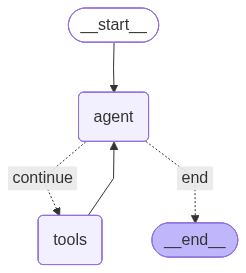

In [5]:
# === Visualize ===
from IPython.display import Image, display
display(Image(agentic_graph.get_graph().draw_mermaid_png()))

In [6]:
import os
from langchain_openai import ChatOpenAI

# ✅ Ensure your API key is in environment
#    (set this before running, e.g. in Colab or terminal)
#    os.environ["OPENAI_API_KEY"] = "sk-..."   # <-- already assumed set

# Initialize the model once
model = ChatOpenAI(
    model="gpt-4o-mini",   # or "gpt-4o"
    temperature=0,         # deterministic for reproducible demos
    api_key=OPENAI_API_KEY
)

def get_llm_response(prompt: str) -> str:
    """
    Get a completion from the LLM using LangChain's ChatOpenAI.
    Relies on OPENAI_API_KEY from environment for authentication.
    """
    try:
        response = model.invoke(prompt)
        return response.content
    except Exception as e:
        print("⚠️ Error calling model:", e)
        return "Error: Unable to retrieve response from LLM."

# # --- Quick Test ---
# if __name__ == "__main__":
#     prompt = "Explain the impact of GenAI on healthcare in 30 words."
#     result = get_llm_response(prompt)
#     print(result)


In [8]:
# --- Run the adapted agent with a recursion limit ---
agent_state = {
    "query": "My weight is 72 kg and my height is 1.75 m. What is my BMI and how much water should I drink per day?",
    "last_agent_response": "",
    "tool_obervations": [],
    "num_steps": 0,
}

# Set recursion limit to 3 in the config
config = {"recursion_limit": 10}

result = agentic_graph.invoke(agent_state, config=config)

print("\n\n=== FINAL RAW TRACE STATE ===")
print(result['last_agent_response'])



=== STEP 0 ===
---CALLING LLM MODEL---
THOUGHT: I need to calculate the BMI first using the provided weight and height, and then I will estimate the recommended daily water intake based on the weight. 
ACTION: calculate_bmi
ARGUMENTS: {"weight_kg":72,"height_m":1.75}
-- Continuing workflow to tools.

---CALLING TOOL---
Tool to call: calculate_bmi
Parsed arguments: {'weight_kg': 72, 'height_m': 1.75}
calculate_bmi returned: 23.510204081632654


=== STEP 1 ===
---CALLING LLM MODEL---
THOUGHT: I have already calculated the BMI, which is approximately 23.51. Now, I need to estimate the recommended daily water intake based on the user's weight. 
ACTION: daily_water_intake
ARGUMENTS: {"weight_kg":72}
-- Continuing workflow to tools.

---CALLING TOOL---
Tool to call: daily_water_intake
Parsed arguments: {'weight_kg': 72}
daily_water_intake returned: 2.52


=== STEP 2 ===
---CALLING LLM MODEL---
THOUGHT: I have already calculated the BMI, which is approximately 23.51. Now, I need to estimate

In [9]:
print(result['last_agent_response'])

THOUGHT: I have already calculated the BMI, which is approximately 23.51. Now, I need to provide the recommended daily water intake based on the user's weight. The previous calculation for daily water intake was already done, and it is approximately 2.52 liters. I can now provide the final answer to the user.  
ANSWER: Your BMI is approximately 23.51, and you should drink about 2.52 liters of water per day.
